In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')
import scipy.stats as st

In [19]:
## download data
#import requests
#payload='target=GHO/MH_12&profile=crosstable&filter=COUNTRY:*;REGION:*&x-sideaxis=COUNTRY&x-topaxis=GHO;YEAR;SEX' 
#suicide_rate_url='http://apps.who.int/gho/athena/data/xmart.csv?' 
#with open('who_suicide_rates.csv', 'wb') as fout:
#    fout.write(requests.get(suicide_rate_url+payload).content)

In [20]:
rates = pd.read_csv('who_suicide_rates.csv', names=['country', 'both', 'male', 'female'], skiprows=3)
rates.head(10)

,country,both,male,female
0,Afghanistan,5.7,6.2,5.3
1,Albania,5.9,6.6,5.2
2,Algeria,1.9,2.3,1.5
3,Angola,13.8,20.7,7.3
4,Argentina,10.3,17.2,4.1
5,Armenia,2.9,5.0,0.9
6,Australia,10.6,16.1,5.2
7,Austria,11.5,18.2,5.4
8,Azerbaijan,1.7,2.4,1.0
9,Bahamas,2.3,3.6,1.3


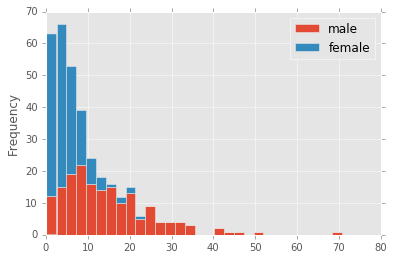

In [21]:
rates.plot.hist(stacked=True, y=['male', 'female'], bins=30)

14.6959064327 5.07076023392
   country  both  male  female
66  Guyana  44.2  70.8    22.1


/Users/kris/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  app.launch_new_instance()


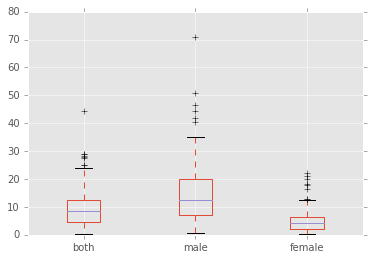

In [22]:
print rates['male'].mean(), rates['female'].mean()
print rates[rates['both'] > 40]
_ = rates.boxplot()

In [23]:
def plot_cdf(data, plot_range=None, scale_to=None, **kwargs): 
    num_bins = len(data)    
    sorted_data = np.array(sorted(data), dtype=np.float64) 
    data_range = sorted_data[-1] - sorted_data[0] 
    counts, bin_edges = np.histogram(sorted_data, bins=num_bins) 
    xvalues = bin_edges[1:] 
    yvalues = np.cumsum(counts) 
    if plot_range is None: 
        xmin = sorted_data[0] 
        xmax = sorted_data[-1] 
    else: 
        xmin, xmax = plot_range 
    #pad the arrays 
    xvalues = np.concatenate([[xmin, xvalues[0]], xvalues, [xmax]]) 
    yvalues = np.concatenate([[0.0, 0.0], yvalues, [yvalues.max()]]) 
    if scale_to is not None: 
        yvalues = yvalues / len(data) * scale_to 
    #print xvalues.shape, yvalues.shape
    return plt.plot(xvalues, yvalues, **kwargs)

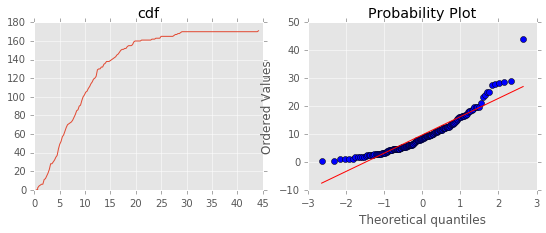

In [24]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plot_cdf(rates['both'])
plt.title('cdf')
plt.subplot(1, 2, 2)
_ = st.probplot(rates['both'], dist='norm', plot=plt)

1.48510646048 0 10.7601092353


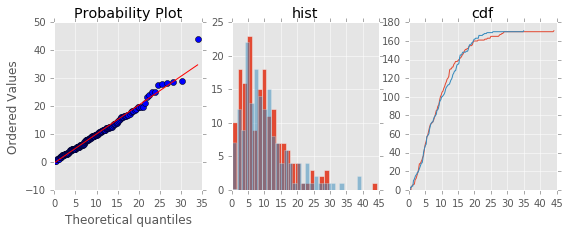

In [25]:
beta, loc, eta = st.weibull_min.fit(rates['both'], floc=0)
print beta, loc, eta
rvWb = st.weibull_min(beta, scale=eta)
plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
st.probplot(rates['both'], dist=rvWb, plot=plt)
plt.subplot(1, 3, 2)
rates['both'].hist(bins=30)
plt.hist(rvWb.rvs(len(rates['both'])), bins=30, alpha=0.5)
plt.title('hist')
plt.subplot(1, 3, 3)
plot_cdf(rates['both'])
plot_cdf(rvWb.rvs(len(rates['both'])))
plt.title('cdf')

In [26]:
# test the assumption that the amount of sunlight in each country is directly proportional to the latitude
# “A simple countries centroid can be found on the Gothos web page: http://gothos.info/2009/02/centroids-for-countries/”
coords = pd.read_csv('country_centroids/country_centroids_primary.csv', sep='\t')
print coords.keys()
print coords.head()

Index([u'LAT', u'LONG', u'DMS_LAT', u'DMS_LONG', u'MGRS', u'JOG', u'DSG',
       u'AFFIL', u'FIPS10', u'SHORT_NAME', u'FULL_NAME', u'MOD_DATE',
       u'ISO3136'],
      dtype='object')
         LAT   LONG  DMS_LAT  DMS_LONG             MGRS      JOG   DSG AFFIL  \
0  33.000000   66.0   330000    660000  42STB1970055286  NI42-09  PCLI   NaN   
1  41.000000   20.0   410000    200000  34TDL1589839239  NK34-08  PCLI   NaN   
2  28.000000    3.0   280000     30000  31REL0000097202  NH31-15  PCLI   NaN   
3 -14.333333 -170.0  -142000  -1700000          1802701      NaN  PCLD    US   
4  42.500000    1.5   423000     13000  31TCH7675006383  NK31-04  PCLI   NaN   

  FIPS10      SHORT_NAME                                FULL_NAME    MOD_DATE  \
0     AF     Afghanistan          Islamic Republic of Afghanistan  2009-04-10   
1     AL         Albania                      Republic of Albania  2007-02-28   
2     AG         Algeria  People's Democratic Republic of Algeria  2011-03-03   
3     AS 

In [27]:
rates['lat'] = ''
rates['lng'] = ''
for i in coords.index:
    ind = rates['country'].isin([coords['SHORT_NAME'][i]])
    val = coords.loc[i, ['LAT', 'LONG']].values.astype('float')
    rates.loc[ind, ['lat', 'lng']] = list(val)
rates.loc[rates['lat'].isin(['']), ['lat']] = np.nan
rates.loc[rates['lng'].isin(['']), ['lng']] = np.nan
print rates[['lat', 'lng']].describe()
rates[['lat', 'lng']] = rates[['lat', 'lng']].astype('float')
#rates.head()

          lat    lng
count   152.0  152.0
unique  113.0  121.0
top      15.0   30.0
freq      4.0    6.0


In [28]:
rates['dfe'] = np.abs(rates['lat'])
rates.head()

,country,both,male,female,lat,lng,dfe
0,Afghanistan,5.7,6.2,5.3,33.0,66.0,33.0
1,Albania,5.9,6.6,5.2,41.0,20.0,41.0
2,Algeria,1.9,2.3,1.5,28.0,3.0,28.0
3,Angola,13.8,20.7,7.3,-12.5,18.5,12.5
4,Argentina,10.3,17.2,4.1,-34.0,-64.0,34.0


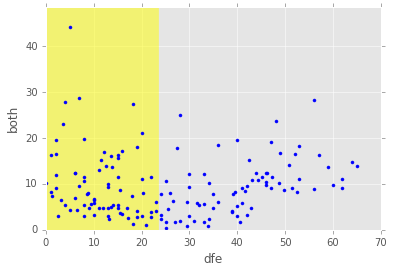

In [29]:
# countries within +/-23.5 degrees away from the equator get an equal amount of 
# sunlight throughout the year, so they should be considered to have the same
# suicide rate according to our hypothesis
plt.plot(rates['dfe'], rates['both'], 'b.')
plt.fill_between([0, 23.5], [100, 100], alpha=0.5, color='yellow')
plt.ylim(0, rates['both'].max()*1.1)
plt.xlabel('dfe')
plt.ylabel('both')

<Container object of 3 artists>

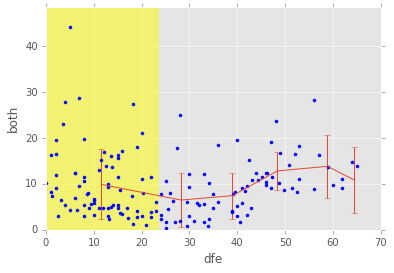

In [30]:
plt.plot(rates['dfe'], rates['both'], 'b.')
plt.fill_between([0, 23.5], [100, 100], alpha=0.5, color='yellow')
plt.ylim(0, rates['both'].max()*1.1)
plt.xlabel('dfe')
plt.ylabel('both')
bins = np.arange(23.5, rates['dfe'].max()+1, 10, dtype='float')
grpRates = rates.groupby(np.digitize(rates['dfe'], bins))
plt.errorbar(grpRates.mean()['dfe'], grpRates.mean()['both'], yerr=grpRates.std()['both'])

<Container object of 3 artists>

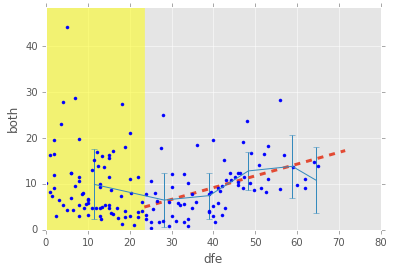

In [31]:
from sklearn.linear_model import LinearRegression
sel = ~rates['dfe'].isnull() * rates['dfe'] > 23.5
mat = rates[sel].as_matrix(columns=['dfe', 'both'])
x = mat[:, 0].reshape(-1, 1)
y = mat[:, 1].reshape(-1, 1)
model = LinearRegression().fit(x, y)
xx = np.linspace(23.5, rates['dfe'].max()*1.1, 200).reshape(-1, 1)
plt.plot(xx, model.predict(xx), '--', lw=3)

plt.plot(rates['dfe'], rates['both'], 'b.')
plt.fill_between([0, 23.5], [100, 100], alpha=0.5, color='yellow')
plt.ylim(0, rates['both'].max()*1.1)
plt.xlabel('dfe')
plt.ylabel('both')
bins = np.arange(23.5, rates['dfe'].max()+1, 10, dtype='float')
grpRates = rates.groupby(np.digitize(rates['dfe'], bins))
plt.errorbar(grpRates.mean()['dfe'], grpRates.mean()['both'], yerr=grpRates.std()['both'])

In [39]:
from pandas.io import wb
# wb.search('gdp.*capita.*').iloc[:, :2]

ValueError: Unmatched ''"' when when decoding 'string'

In [34]:
dat = wb.download(indicator='NY.GDP.PCAP.PP.CD', country='all', start=2014, end=2014)
dat.head()

,,NY.GDP.PCAP.PP.CD
country,year,
Arab World,2014,16115.995314
Caribbean small states,2014,15414.618208
Central Europe and the Baltics,2014,25049.842603
Early-demographic dividend,2014,8296.173693
East Asia & Pacific,2014,15280.986024


In [35]:
countries = np.array(dat.index.tolist())[:, 0]
gdp = np.array(dat['NY.GDP.PCAP.PP.CD'])
data = pd.DataFrame(data=np.hstack((countries.reshape(-1, 1), gdp.reshape(-1, 1))), columns=['countries', 'gdp'])
data.head()

,countries,gdp
0,Arab World,16115.9953143
1,Caribbean small states,15414.6182079
2,Central Europe and the Baltics,25049.8426029
3,Early-demographic dividend,8296.17369266
4,East Asia & Pacific,15280.9860235


In [36]:
rates['gdp'] = ''
for i in np.arange(len(data)):
    ind = rates['country'].isin([data['countries'][i]])
    val = data.loc[i, ['gdp']].values.astype('float')
    rates.loc[ind, ['gdp']] = val
rates.loc[rates['gdp'].isin(['']), ['gdp']] = np.nan

In [37]:
print rates[rates['country'] == 'Sweden']
print data[data['countries'] == 'Sweden']

    country  both  male  female   lat   lng   dfe      gdp
146  Sweden  11.1  16.2     6.1  62.0  15.0  62.0  46445.8
    countries            gdp
234    Sweden  46445.7719135


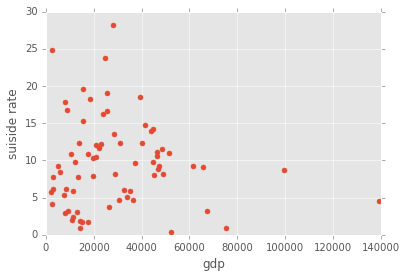

In [40]:
sel = (~rates['dfe'].isnull()) * (rates['dfe'] > 23.5) 
sel *= (~rates['gdp'].isnull())
plt.plot(rates[sel]['gdp'], rates[sel]['both'], '.', ms=10)
plt.xlabel('gdp')
plt.ylabel('suicide rate')

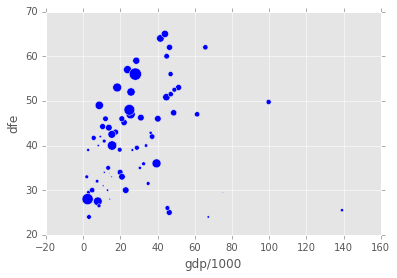

In [45]:
plt.scatter(rates[sel]['gdp']/1000, rates[sel]['dfe'], s=rates[sel]['both']**1.5)
plt.xlabel('gdp/1000')
plt.ylabel('dfe')

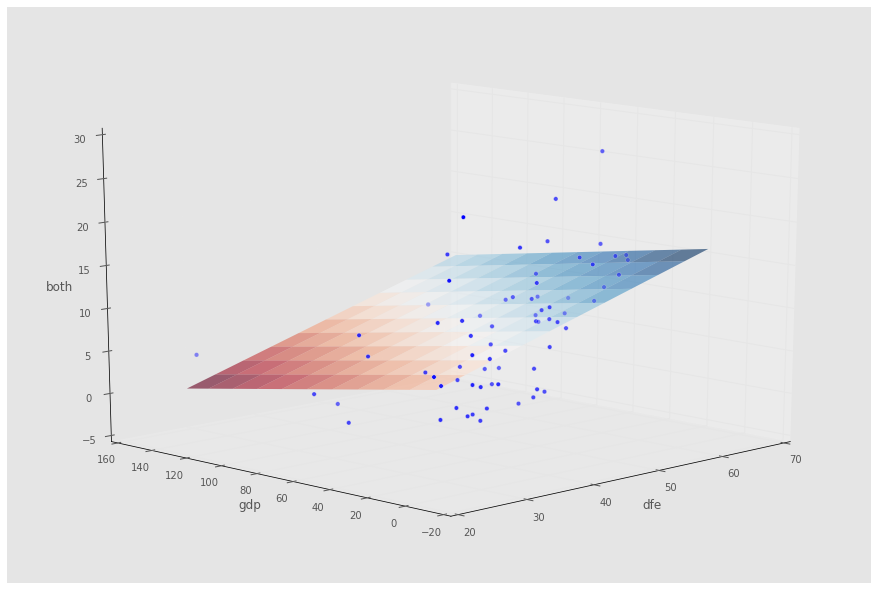

In [74]:
from mpl_toolkits.mplot3d import Axes3D
mat = rates[sel].as_matrix(columns=['dfe', 'gdp'])
mat[:, 1] /= 1000
z = rates[sel].as_matrix(columns=['both'])
model = LinearRegression().fit(mat, y)
xx, yy = np.meshgrid(np.linspace(mat[:, 0].min(), mat[:, 0].max(), 100),
                  np.linspace(mat[:, 1].min(), mat[:, 1].max(), 100))
z2 = model.predict(np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1)))).reshape(100, 100)
# z2 = xx*model.coef_[0][0] + yy*model.coef_[0][1] + model.intercept_[0]
# print z2.shape, model.coef_, model.intercept_
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, azim=-135, elev=15)
surf = ax.plot_surface(xx, yy, z2, cmap=plt.cm.RdBu, alpha=0.6, linewidth=0)
ax.scatter(mat[:, 0], mat[:, 1], z)
ax.set_xlabel('dfe')
ax.set_ylabel('gdp')
ax.set_zlabel('both')

In [70]:
# data = pd.DataFrame(rates[['country', 'both', 'male', 'female', 'dfe', 'gdp']])[~rates['dfe'].isnull()]
# data.to_hdf('ch4data.h5', 'ch4data', mode='w', table=True, encoding='utf8')
# data.head()

,country,both,male,female,dfe,gdp
0,Afghanistan,5.7,6.2,5.3,33.0,1942.48
1,Albania,5.9,6.6,5.2,41.0,11307.5
2,Algeria,1.9,2.3,1.5,28.0,14277.6
3,Angola,13.8,20.7,7.3,12.5,7327.38
4,Argentina,10.3,17.2,4.1,34.0,19880.7


In [71]:
# d2 = pd.read_hdf('ch4data.h5')
# d2.head()

,country,both,male,female,dfe,gdp
0,Afghanistan,5.7,6.2,5.3,33.0,1942.48
1,Albania,5.9,6.6,5.2,41.0,11307.5
2,Algeria,1.9,2.3,1.5,28.0,14277.6
3,Angola,13.8,20.7,7.3,12.5,7327.38
4,Argentina,10.3,17.2,4.1,34.0,19880.7
